In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar

from json_data_getter import get_all_json

# Data preparation

## Loading

In [2]:
# gets all the json files toghether, may take a minute
_, _, documents = get_all_json()
df = pd.DataFrame.from_dict(documents)

100% (109 of 109) |########################################| Elapsed Time: 0:00:14 Time: 0:00:14


## Cleaning

In [3]:
# keep NaN for float columns, empty strings for string columns
with progressbar.ProgressBar(max_value=len(df.columns)) as bar:        
    for i,col in enumerate(df):
        # get dtype for column
        dt = df[col].dtype
        # check if it is a number
        if dt == int or dt == float:
            pass
        else:
            df[col].fillna("", inplace=True)
        bar.update(i)

# set dates to datetime type
df['publicationDate'] = pd.to_datetime(
    df['publicationDate'], format='%Y-%m-%dT%H:%M:%SZ')

100% (27 of 27) |##########################################| Elapsed Time: 0:00:00 Time: 0:00:00


In [4]:
df.columns.values

array(['alternativeExcerpt', 'alternativeTitle', 'articleURL',
       'backgrounds', 'contributors', 'durationSec', 'excerpt', 'genres',
       'id', 'imageURL', 'isOnline', 'mediaType', 'mediaURL', 'program',
       'publicationChannelNames', 'publicationDate', 'source',
       'thematicCorporations', 'thematicGeographicals', 'thematicPersons',
       'thematicThemes', 'title', 'variantIds', 'visualCorporations',
       'visualGeographicals', 'visualPersons', 'visualThemes'], dtype=object)

## distribution in time

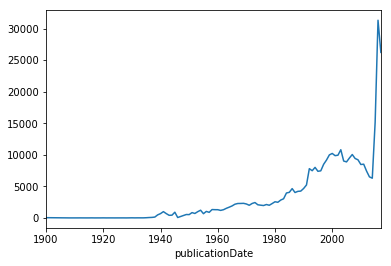

In [5]:
doc_per_year = df.groupby(df.publicationDate.map(lambda x: x.year)).size()
doc_per_year.plot()
plt.show()

## Programs lifespan

In [6]:
def get_program_lifespan(df):
    program_groups = df.groupby(df.program)
    df_lifespan = program_groups.publicationDate.agg(['min', 'max', 'size'])
    df_lifespan['lifespan_days'] = (
        df_lifespan['max'] - df_lifespan['min']).astype('timedelta64[D]')
    return df_lifespan

In [7]:
get_program_lifespan(df).sort_values('lifespan_days', ascending=False).head()

,min,max,size,lifespan_days
program,,,,
,1900-01-01 00:00:00,2017-11-15 00:00:00,20458,43052.0
TJ midi,1900-01-01 19:00:00,2011-12-04 11:45:00,204,40878.0
Marabout de ficelle,1900-01-01 00:00:00,1998-05-20 00:00:00,148,35933.0
Mémoires de la musique,1922-06-05 00:00:00,2004-01-23 00:00:00,2086,29817.0
Archives,1939-11-30 02:00:00,2017-10-03 13:10:37,120,28432.0


The first row is the group of unnamed programs. Some duration seem a bit too long, maybe there are errors in the dates. Let's take TJ midi and check the distribution of transmissions by year.

In [8]:
def plot_program_lifespan(program, df):
    program_groups = df.groupby(df.program)
    group = program_groups.get_group(program)
    date_distribution = group.groupby(
        group.publicationDate.map(lambda x: (x.year))).size()
    plt.bar(date_distribution.index, date_distribution.values)
    plt.show()

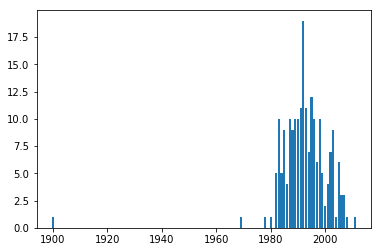

In [9]:
plot_program_lifespan('TJ midi', df)

There are some obvious outliers, let's remove them.

### Date outliers removal

In [10]:
# remove date outliers
def remove_date_outliers(df):
    CONSTANT_STD = 2
    df_without_date_outliers = df.copy()

    df['publicationDateYear'] = df.publicationDate.map(lambda x: x.year)

    mean_std_year_per_program = df.groupby(df.program).publicationDateYear.agg(
        ["mean", 'std'])

    temp_df = pd.merge(
        df,
        mean_std_year_per_program,
        how='left',
        left_on=['program'],
        right_index=True)

    df_without_date_outliers.loc[
        (np.abs(temp_df.publicationDateYear - temp_df['mean']) >
         CONSTANT_STD * temp_df['std']), 'publicationDate'] = pd.NaT

    return df_without_date_outliers

In [11]:
df_without_date_outliers = remove_date_outliers(df)
get_program_lifespan(df_without_date_outliers).sort_values(
    'size', ascending=False).head()

,min,max,size,lifespan_days
program,,,,
Journal du matin,1989-01-07 00:00:00,2017-08-28 00:00:00,21767,10460.0
,1921-11-23 00:00:00,2017-11-15 00:00:00,20458,35056.0
Forum,2004-12-26 23:00:00,2017-11-16 00:00:00,10633,4707.0
Télé journal,1982-01-01 00:00:00,1996-09-30 23:00:00,10520,5386.0
Journal de midi,1982-01-09 00:00:00,2017-08-01 00:00:00,8440,12988.0


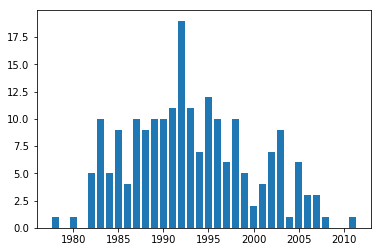

In [12]:
plot_program_lifespan('TJ midi', df_without_date_outliers)

# Gender (Sina)

# Location (Mohammed)

# Factors for program lifespan (Leo)

## Lifespan category

In [20]:
lifespan = get_program_lifespan(df_without_date_outliers)
lifespan['lifespan_class'] = (pd.qcut(
    lifespan.lifespan_days, 5, labels=[0, 1, 2, 3, 4]))

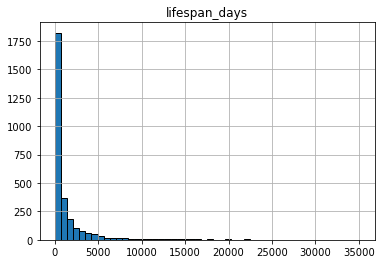

In [21]:
lifespan.hist(column='lifespan_days', bins=50, ec='black')
plt.show()

In [23]:
lifespan.head()

,min,max,size,lifespan_days,lifespan_class
program,,,,,
,1921-11-23 00:00:00,2017-11-15 00:00:00,20458,35056.0,4
Les petits plats dans l'écran,1978-06-04 23:00:00,1979-09-17 01:00:00,9,469.0,2
"""Demain à la une""",2000-09-05 00:00:00,2001-06-15 00:00:00,170,283.0,2
#DansTaToile,2015-11-18 00:00:00,2016-01-20 00:00:00,7,63.0,1
02 à la Une,2002-05-14 00:00:00,2002-10-19 00:00:00,111,158.0,2


## Themes per period

In [13]:
from collections import Counter
def list_flatter(values):
    return [item for sublist in values for item in sublist]
    #return Counter([item for sublist in values for item in sublist]).most_common()

In [28]:
# TODO, problem : cannot reduce when adding other columns

counters_program_period = df_without_date_outliers.groupby([
    df_without_date_outliers.program,
    df_without_date_outliers.publicationDate.apply(lambda x: x.year)
])[
    #'genres', 'publicationChannelNames', 'thematicCorporations','thematicGeographicals','thematicPersons',
    #'thematicThemes', 'visualCorporations', 'visualGeographicals', 'visualPersons',
    'thematicGeographicals',
    'thematicThemes',
    'visualThemes'
].agg(list_flatter)

In [15]:
def get_themes(fr, to, theme_type, program=-1, n_top=3):
    rows_selection = ((counters_program_period.index.get_level_values('publicationDate') >= fr) &
    (counters_program_period.index.get_level_values('publicationDate') <= to))
    
    if program != -1:
        rows_selection = rows_selection & (counters_program_period.index.get_level_values('program') == program)
        
    temp_sum = counters_program_period.loc[rows_selection][theme_type].sum()
    if not isinstance(temp_sum, list):
        temp_sum = []
    return Counter(temp_sum).most_common(n_top)

def get_topn_themes(fr, to='', theme_type='thematicThemes', program=-1,n_top = 3):
    if not to:
        to = fr
    
    columns_name = ['top' + str(i+1) for i in range(n_top)]
    themes_per_year = pd.DataFrame(columns=columns_name)
    
    for i in range(fr, to+1):
        temp_themes = get_themes(
            i,
            i+1,
            theme_type,
            program,
            n_top
        )

        top_themes = [''] * n_top
        for j in range(min(n_top, len(temp_themes))):
            top_themes[j] = (temp_themes[j][0])

        themes_per_year.loc[i] = top_themes
    return themes_per_year

## Themes in periods

In [49]:
thematicThemes_per_year = get_topn_themes(1990,2000,'thematicThemes', 'Temps présent',n_top=10)
visualThemes_per_year = get_topn_themes(1900,2017,'visualThemes')
#thematicPersons_per_year = theme_per_year('thematicPersons')
#thematicGeographicals_per_year = theme_per_year('thematicGeographicals')
#thematicCorporations_per_year = theme_per_year('thematicCorporations')

In [50]:
thematicThemes_per_year

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
1990,MANIFESTATION POLITIQUE,CÉRÉMONIE RELIGIEUSE,ARMÉE,LOGEMENT,ENTREPRISE,SCÈNE DE RUE,CONFLIT ARMÉ,ÉCOLOGISME,CHÔMAGE,FAMILLE
1991,MANIFESTATION POLITIQUE,ENFANT (ÂGE),ARMÉE,CÉRÉMONIE RELIGIEUSE,AGRICULTEUR,NATIONALISME,CONFLIT ARMÉ,ÉCONOMIE CAPITALISTE,ÉCOLOGISME,DÉCHET
1992,RACISME,CHÔMAGE,ENFANT (ÂGE),ARMÉE,ÉCONOMIE,POLITIQUE,PRISON,IMMIGRATION,MANIFESTATION POLITIQUE,AGRICULTEUR
1993,CHÔMAGE,ÉCONOMIE CAPITALISTE,BÉBÉ,ADOLESCENCE,BANANE,JUIFS,NAZISME,GUERRE MONDIALE (DEUXIÈME),PLACEMENT FAMILIAL,TRAVAIL À TEMPS PARTIEL
1994,CRISE ÉCONOMIQUE,ADOLESCENCE,VIEILLESSE,QUARTIER,BANLIEUE,SUICIDE,HOMICIDE,SECTE,ENQUÊTE CRIMINELLE,HOMOSEXUALITÉ
1995,TRAVAIL DES FEMMES,VIEILLESSE,MONARCHIE,NOBLESSE,VEDETTARIAT,BAL,PRESSE À SENSATION,PLAN DE PAIX,CONFLIT YOUGOSLAVE,CONTREFAÇON
1996,JUIFS,PAUVRETÉ,TRAVAIL DE NUIT,TRAVAIL DES FEMMES,SYNDICAT,CONDITION DE TRAVAIL,ANNÉES 1990,FEMME BATTUE,VIOLENCE,DÉPÔT BANCAIRE
1997,JUIFS,ANTISÉMITISME,PAUVRETÉ,QUART-MONDE,ARMÉE,BANQUE,GUERRE MONDIALE (DEUXIÈME),TÉLÉPHONE MOBILE,HISTOIRE,POLITIQUE
1998,RETRAITE (ÉTAT),VIE SOCIALE,AMÉRINDIENS,NOMADISME,VIEILLESSE,REFOULEMENT DES ÉTRANGERS,REQUÉRANT D'ASILE,FÉCONDATION ARTIFICIELLE,GÉNIE GÉNÉTIQUE,SNOWBOARD (COMPÉTITION)
1999,VILLE CANDIDATE AUX JEUX OLYMPIQUES,OLYMPISME,ACCIDENT AÉRIEN,MD11,PILOTE DE LIGNE,SÉCURITÉ AÉRIENNE,CONSEILLER FÉDÉRAL,FONCTION POLITIQUE,COMMERCE ÉLECTRONIQUE,AMOUR


### example of visualization
<img src="wordcloud_example_thematic2017.png">
This image was generated with https://www.wordclouds.com/. ThematicThemes from all programs of 2017